In [31]:
import lightgbm as lgb
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [32]:
supply_data= pd.read_csv('C:/Users/Patron/Desktop/study/fin 850/SupplyData.csv')
supply_data['Date'] = pd.to_datetime(supply_data['Date'])
supply_data = supply_data.sort_values('Date')
supply_data['Supply'] = supply_data['Supply'].str.replace(',', '').astype(float)
supply_data.set_index('Date', inplace=True)  # Set as index

In [33]:
# Step 1: Fit SARIMA model
sarima_model = SARIMAX(
    supply_data['Supply'], 
    order=(2, 1, 0),  # ARIMA (p, d, q)
    seasonal_order=(2, 1, 0, 72),  # Seasonal (P, D, Q, s) with weekly seasonality
    enforce_stationarity=False,
    enforce_invertibility=False
).fit()

C:\Users\Patron\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Patron\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


In [34]:
# Step 2: Compute residuals from SARIMA
supply_data['SARIMA_Forecast'] = sarima_model.fittedvalues
supply_data['Residuals'] = supply_data['Supply'] - supply_data['SARIMA_Forecast']

# Step 3: Create lagged features for residuals
lags = 5  # Number of lagged features
for lag in range(1, lags + 1):
    supply_data[f'Lag_{lag}'] = supply_data['Residuals'].shift(lag)

# Drop rows with NaN values caused by lagging
lgbm_data = supply_data.dropna()



In [35]:
# Step 4: Prepare features and target for LightGBM
X = lgbm_data[[f'Lag_{lag}' for lag in range(1, lags + 1)]]
y = lgbm_data['Residuals']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train LightGBM on residuals
lgb_train = lgb.Dataset(X_train, label=y_train)
lgb_params = {
    'objective': 'regression',
    'metric': 'rmse',
    'boosting_type': 'gbdt',
    'learning_rate': 0.05,
    'num_leaves': 31,  # Increase number of leaves
    'max_depth': -1,   # Allow deeper trees
    'lambda_l1': 0.1,  # Lower L1 regularization
    'lambda_l2': 0.1,  # Lower L2 regularization
    'min_data_in_leaf': 5  # Allow smaller leaf sizes
}
lgb_model = lgb.train(lgb_params, lgb_train, num_boost_round=100)

# Step 5: Forecast residuals using LightGBM
future_lags = np.array([lgbm_data['Residuals'][-lags:].values])  # Use last known residuals
future_lgbm_residuals = []

for _ in range(30):  # Forecast for 30 days
    future_lags_df = pd.DataFrame(future_lags, columns=[f'Lag_{i+1}' for i in range(future_lags.shape[1])])
    pred_residual = lgb_model.predict(future_lags_df)[0]
    future_lgbm_residuals.append(pred_residual)
    future_lags = np.roll(future_lags, -1)  # Shift lags
    future_lags[0, -1] = pred_residual  # Update last lag with predicted residual



[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000171 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 977
[LightGBM] [Info] Number of data points in the train set: 586, number of used features: 5
[LightGBM] [Info] Start training from score -73203.841759


C:\Users\Patron\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\Patron\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


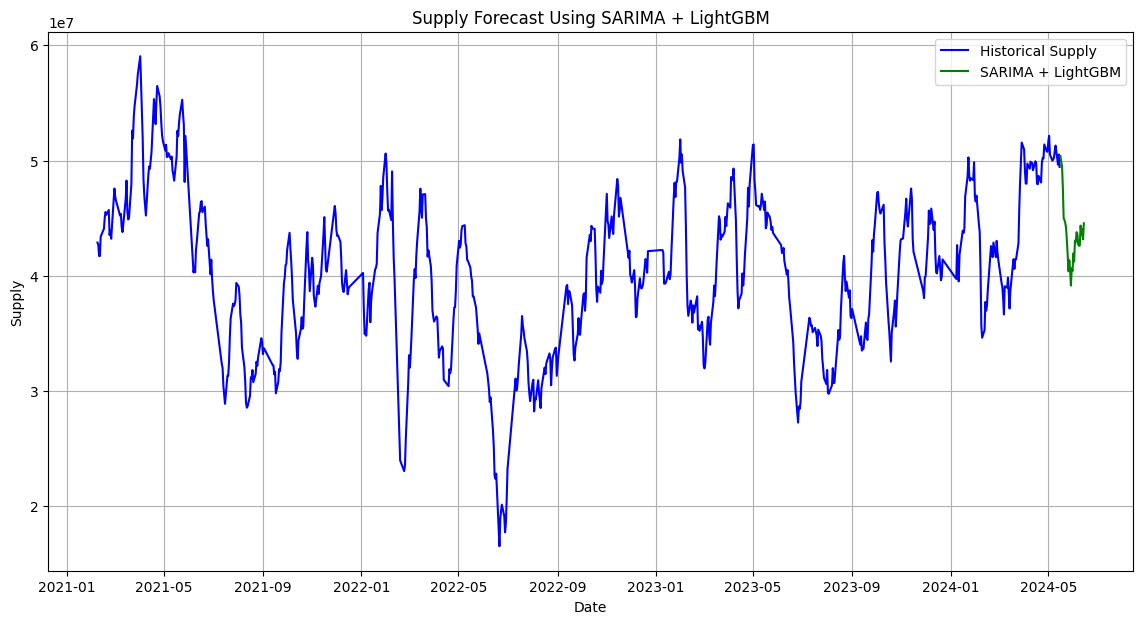

In [36]:
# Step 6: Combine SARIMA and LightGBM predictions
future_sarima = sarima_model.get_forecast(steps=30).predicted_mean
alpha = 0.7  # Weight for SARIMA
final_forecast = alpha * future_sarima + (1 - alpha) * np.array(future_lgbm_residuals)

final_forecast = future_sarima + np.array(future_lgbm_residuals)

# Step 7: Plot results
forecast_index = pd.date_range(start=supply_data.index[-1] + pd.Timedelta(days=1), periods=30, freq='D')

plt.figure(figsize=(14, 7))
plt.plot(supply_data['Supply'], label='Historical Supply', color='blue')
plt.plot(forecast_index, final_forecast, label='SARIMA + LightGBM', color='green')
plt.title('Supply Forecast Using SARIMA + LightGBM')
plt.xlabel('Date')
plt.ylabel('Supply')
plt.legend()
plt.grid(True)
plt.show()



In [37]:
# Step 8: Display forecasted values
forecast_df = pd.DataFrame({
    "Date": forecast_index,
    "Forecasted Supply": final_forecast
})
forecast_df

,Date,Forecasted Supply
738,2024-05-16,5.038130e+07
739,2024-05-17,4.987811e+07
740,2024-05-18,4.950320e+07
741,2024-05-19,4.767382e+07
742,2024-05-20,4.500029e+07
743,2024-05-21,4.483668e+07
744,2024-05-22,4.458120e+07
745,2024-05-23,4.412530e+07
746,2024-05-24,4.307713e+07
747,2024-05-25,4.178008e+07


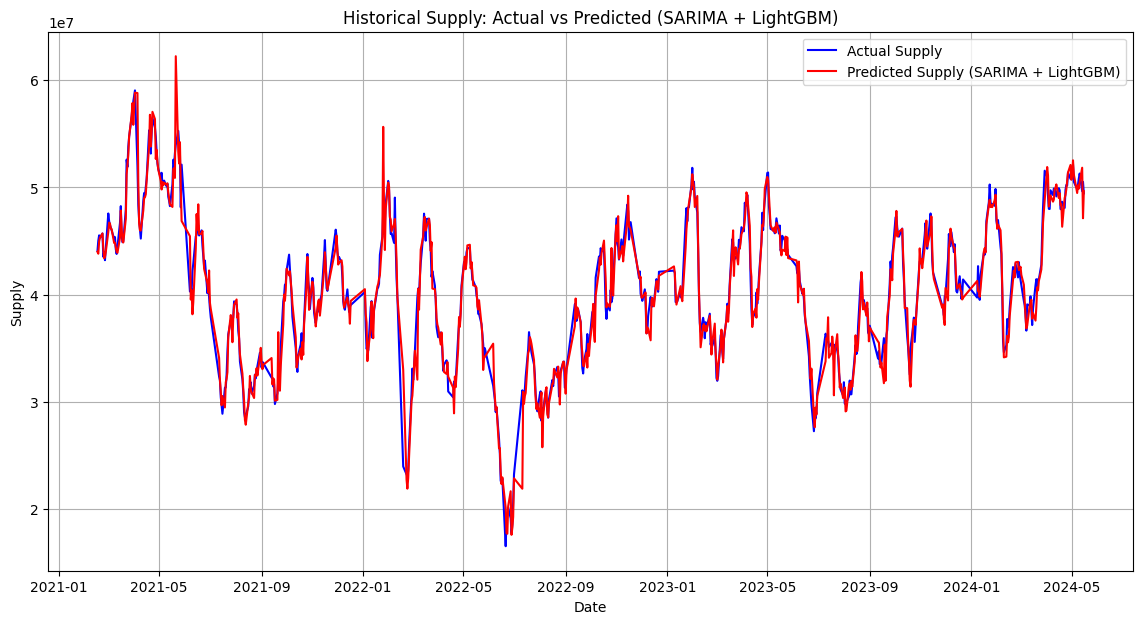

In [38]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Step 1: Combine SARIMA and LightGBM predictions for historical data (training period)
# Use SARIMA's fitted values and LightGBM's residual predictions
historical_residuals_pred = lgb_model.predict(X)
historical_sarima_pred = lgbm_data['SARIMA_Forecast']
historical_combined_pred = historical_sarima_pred + historical_residuals_pred

# Actual values
historical_actual = lgbm_data['Supply']

# Step 2: Calculate evaluation metrics
mae = mean_absolute_error(historical_actual, historical_combined_pred)
rmse = np.sqrt(mean_squared_error(historical_actual, historical_combined_pred))
r2 = r2_score(historical_actual, historical_combined_pred)

# Display metrics
metrics = {
    "Mean Absolute Error (MAE)": mae,
    "Root Mean Squared Error (RMSE)": rmse,
    "R-squared (R2)": r2
}
metrics

# Step 3: Plot actual vs. predicted for historical data
plt.figure(figsize=(14, 7))
plt.plot(historical_actual.index, historical_actual, label='Actual Supply', color='blue')
plt.plot(historical_actual.index, historical_combined_pred, label='Predicted Supply (SARIMA + LightGBM)', color='red')
plt.title('Historical Supply: Actual vs Predicted (SARIMA + LightGBM)')
plt.xlabel('Date')
plt.ylabel('Supply')
plt.legend()
plt.grid(True)
plt.show()


In [39]:
metrics

{'Mean Absolute Error (MAE)': np.float64(890323.6971379237),
 'Root Mean Squared Error (RMSE)': np.float64(1377123.2285311334),
 'R-squared (R2)': 0.9614778556346837}